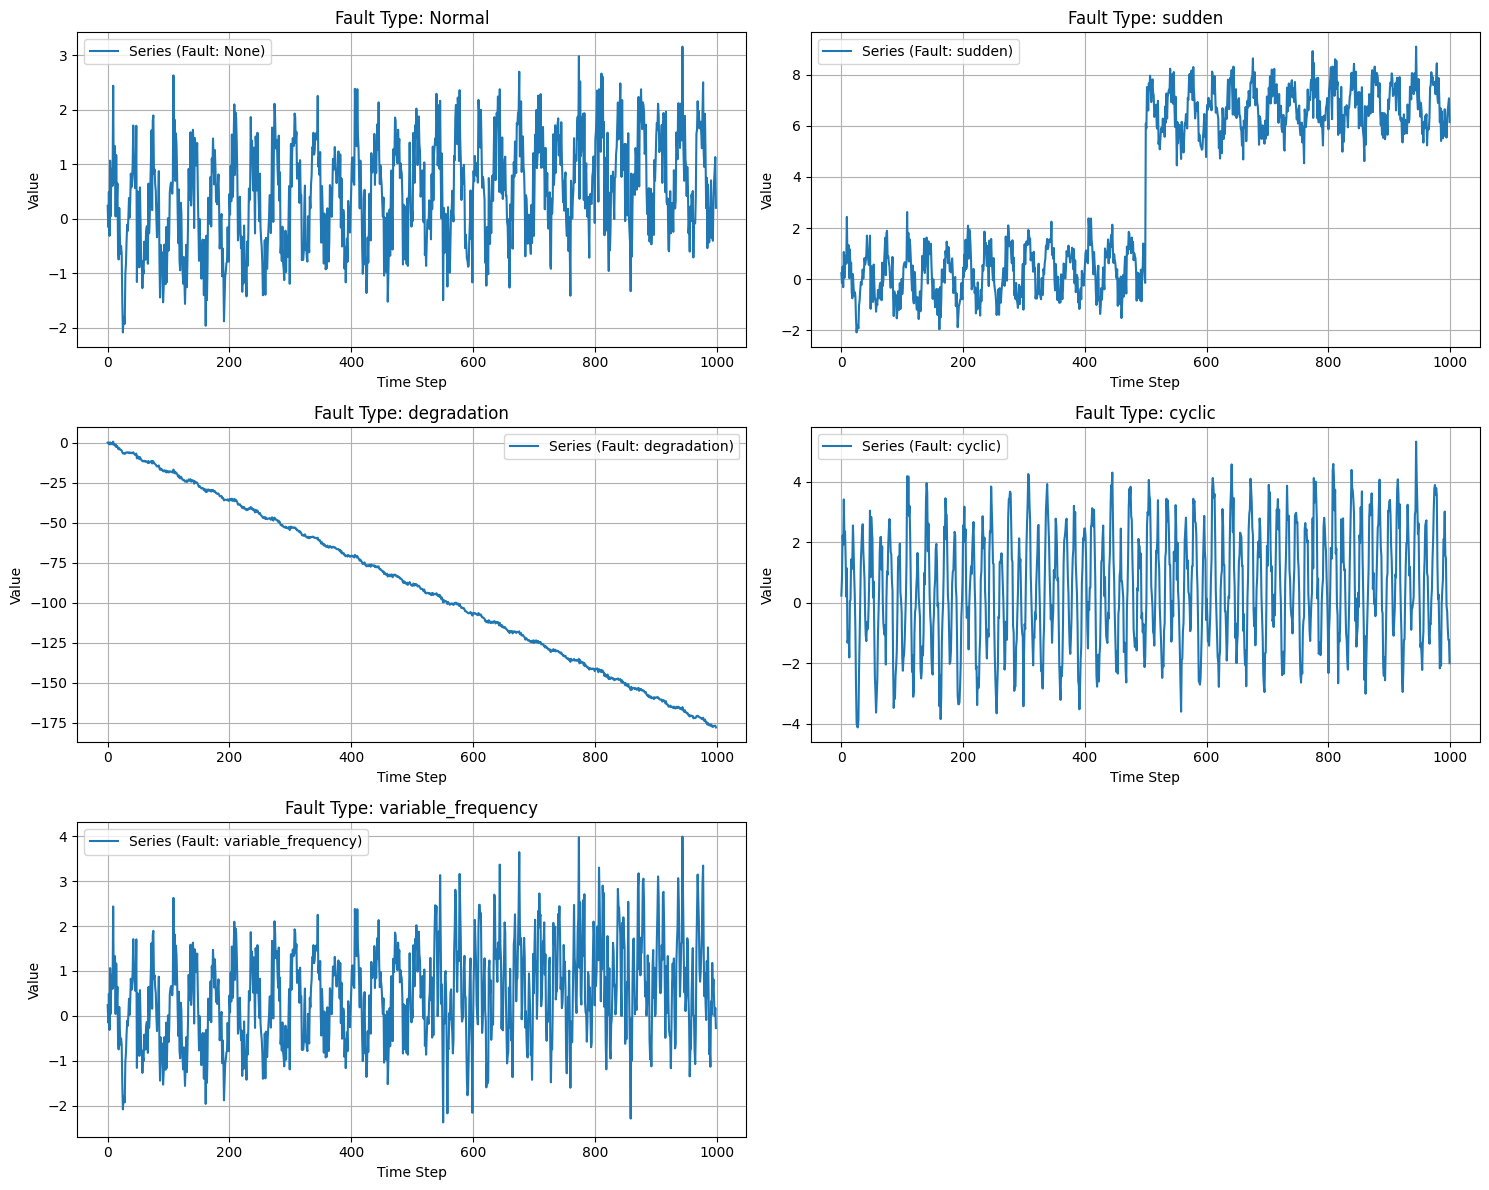

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def generate_synthetic_series_variable_frequency(
    length=500,
    trend_type="linear",
    noise_level=0.1,
    oscillation_amplitude=1.0,
    initial_frequency=0.05,
    fault_type=None,  # Choose from "sudden", "degradation", "cyclic", "variable_frequency", or None
    seed=None
):
    """
    Generate a synthetic time series with various fault types, including variable frequency noise.

    Parameters:
        length (int): Length of the time series.
        trend_type (str): Type of trend ("linear", "quadratic", or "none").
        noise_level (float): Standard deviation of Gaussian noise.
        oscillation_amplitude (float): Amplitude of sinusoidal oscillations.
        initial_frequency (float): Initial frequency of sinusoidal oscillations.
        fault_type (str or None): Type of fault ("sudden", "degradation", "cyclic", "variable_frequency", or None).
        seed (int): Random seed for reproducibility.

    Returns:
        np.ndarray: Synthetic time series.
        np.ndarray: Fault label (single value indicating the fault type).
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate trend
    if trend_type == "linear":
        trend = np.linspace(0, 1, length)
    elif trend_type == "quadratic":
        trend = np.linspace(0, 1, length) ** 2
    else:
        trend = np.zeros(length)

    # Generate oscillations
    time = np.arange(length)
    oscillations = oscillation_amplitude * np.sin(2 * np.pi * initial_frequency * time)

    # Add noise
    noise = np.random.normal(0, noise_level, length)

    # Combine components
    series = trend + oscillations + noise

    # Apply a single fault type to the entire series
    labels = np.zeros(length)  # Default to "normal" (0)
    if fault_type == "sudden":
        # Add a single large jump in the middle of the series
        sudden_offset = np.random.normal(5 * oscillation_amplitude, 0.5)
        mid_idx = length // 2
        series[mid_idx:] += sudden_offset
        labels[:] = 1  # Label for sudden fault
    elif fault_type == "degradation":
        # Apply a linear degradation trend
        degradation_slope = -np.random.uniform(0.05, 0.2)
        series += degradation_slope * np.arange(length)
        labels[:] = 2  # Label for degradation fault
    elif fault_type == "cyclic":
        # Add stronger cyclic oscillations throughout the series
        cyclic_amplitude = np.random.uniform(1.5, 2.5) * oscillation_amplitude
        cyclic_frequency = initial_frequency * np.random.uniform(2, 5)
        series += cyclic_amplitude * np.sin(2 * np.pi * cyclic_frequency * time)
        labels[:] = 3  # Label for cyclic fault
    elif fault_type == "variable_frequency":
        # Increase the frequency of oscillations from a random point onwards
        t_change = np.random.randint(length // 10, length - length // 10)  # Random instant t
        high_frequency = initial_frequency * np.random.uniform(3, 6)
        series[t_change:] += oscillation_amplitude * np.sin(
            2 * np.pi * high_frequency * np.arange(length - t_change)
        )
        labels[:] = 4  # Label for variable frequency fault

    return series, labels

# Example usage
if __name__ == "__main__":
    # Parameters for series generation
    length = 1000
    fault_types = [None, "sudden", "degradation", "cyclic", "variable_frequency"]
    
    # Generate and plot series for each fault type
    plt.figure(figsize=(15, 12))
    for i, fault in enumerate(fault_types, 1):
        series, labels = generate_synthetic_series_variable_frequency(
            length=length,
            trend_type="linear",
            noise_level=0.5,
            oscillation_amplitude=1.0,
            initial_frequency=0.03,
            fault_type=fault,
            seed=12
        )
        plt.subplot(3, 2, i)
        plt.plot(series, label=f"Series (Fault: {fault or 'None'})")
        plt.title(f"Fault Type: {fault or 'Normal'}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()


In [53]:
import numpy as np
from scipy.signal import detrend

def measure_noise_level(time_series, method="variance", detrend_method="linear"):
    """
    Measure the noise level in a time series.

    Parameters:
        time_series (np.ndarray): The time series data.
        method (str): Method to measure noise ("variance", "mad", "snr").
            - "variance": Variance of the residual (default).
            - "mad": Mean Absolute Deviation of the residual.
            - "snr": Signal-to-Noise Ratio (higher value means less noise).
        detrend_method (str): Method to detrend the series ("linear", "constant").
            - "linear": Remove a linear trend.
            - "constant": Remove the mean only.

    Returns:
        float: Noise level metric.
    """

    
    # Detrend the series
    residual = detrend(time_series, type='linear')

    noise_level = np.var(residual)
    
    return noise_level

# Example usage
if __name__ == "__main__":
    # Generate a synthetic time series with noise
    np.random.seed(42)
    length = 1000
    time = np.linspace(0, 10, length)
    signal = 2 * np.sin(1 * np.pi * 0.5 * time)  # Sinusoidal signal
    noise = np.random.normal(0, 10, length)     # Add Gaussian noise
    series = signal + noise

    # Measure noise level
    variance_noise = measure_noise_level(series, method="variance", detrend_method="linear")
    mad_noise = measure_noise_level(series, method="mad", detrend_method="linear")
    snr = measure_noise_level(series, method="snr", detrend_method="linear")

    print(f"Variance of noise: {variance_noise:.4f}")
    print(f"Mean Absolute Deviation (MAD) of noise: {mad_noise:.4f}")
    print(f"Signal-to-Noise Ratio (SNR): {snr:.4f}")

Variance of noise: 97.6510
Mean Absolute Deviation (MAD) of noise: 97.6510
Signal-to-Noise Ratio (SNR): 97.6510


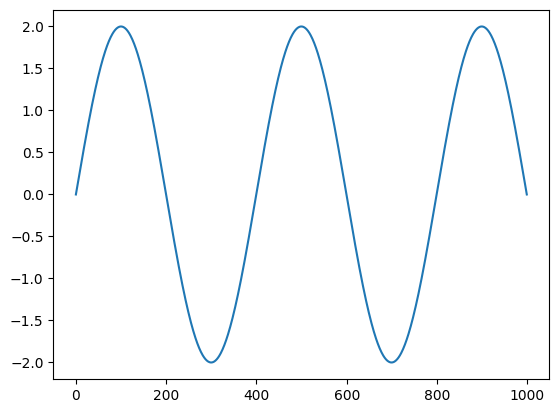

In [51]:
plt.plot(series)

Top 3 frequencies and their amplitudes:


TypeError: cannot unpack non-iterable numpy.float64 object

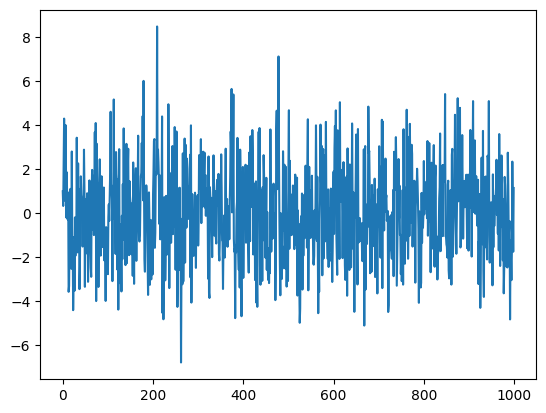

In [57]:
def extract_top_frequencies(time_series, sampling_rate=1, top_n=3):
    """
    Extracts the top N most representative frequencies from a time series.
    
    Parameters:
        time_series (np.ndarray): The input time series data.
        sampling_rate (float): Sampling rate of the series (default is 1 Hz).
        top_n (int): Number of top frequencies to extract (default is 3).
        
    Returns:
        list of tuples: [(frequency1, amplitude1), (frequency2, amplitude2), ...] sorted by amplitude.
    """
    time_series = (time_series - time_series.min()) / (time_series.max() - time_series.min() + 1E-7)
    
    # Length of the time series
    n = len(time_series)
    
    # Apply FFT and compute frequencies
    fft_result = np.fft.fft(time_series)
    frequencies = np.fft.fftfreq(n, d=1/sampling_rate)
    
    # Compute the amplitude spectrum
    amplitudes = np.abs(fft_result)
    
    # Exclude the DC component (frequency 0)
    nonzero_indices = np.where(frequencies > 0)
    frequencies = frequencies[nonzero_indices]
    amplitudes = amplitudes[nonzero_indices]
    
    # Find the top N frequencies based on amplitudes
    top_indices = np.argsort(amplitudes)[-top_n:][::-1]
    top_frequencies = [frequencies[i] for i in top_indices]
    
    return top_frequencies

# Example usage
if __name__ == "__main__":
    # Generate a synthetic time series with multiple frequencies
    np.random.seed(42)
    sampling_rate = 100  # 100 Hz
    time = np.linspace(0, 10, 1000)  # 10 seconds of data
    signal = (np.sin(2 * np.pi * 3 * time) +     # Frequency 3 Hz
              0.5 * np.sin(2 * np.pi * 7 * time) +  # Frequency 7 Hz
              0.3 * np.sin(2 * np.pi * 12 * time))  # Frequency 12 Hz
    noise = np.random.normal(0, 2, len(time))  # Add some noise
    time_series = signal + noise


    plt.plot(time_series)
    # Extract the top 3 frequencies
    top_frequencies = extract_top_frequencies(time_series, sampling_rate=sampling_rate, top_n=3)
    print("Top 3 frequencies and their amplitudes:")
    for freq, amp in top_frequencies:
        print(f"Frequency: {freq:.2f} Hz, Amplitude: {amp:.4f}")

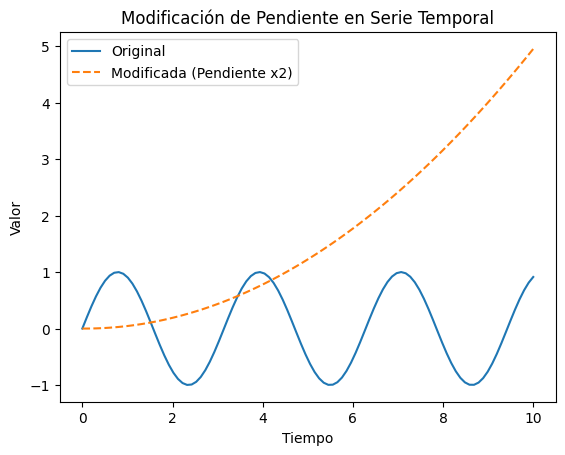

In [18]:
import numpy as np

def modificar_pendiente(serie_temporal, factor_pendiente):
    """
    Modifica la pendiente de una serie temporal ajustando su tasa de cambio.

    Args:
        serie_temporal (numpy.ndarray): Serie temporal original (1D).
        factor_pendiente (float): Factor por el que se multiplicará la pendiente.

    Returns:
        numpy.ndarray: Serie temporal con pendiente modificada.
    """
    # Calcular las diferencias entre valores consecutivos (pendientes locales)
    deltas = np.linspace(0, 1, serie_temporal.shape[0]-1) #np.diff(serie_temporal)
    
    # Escalar las diferencias por el factor de pendiente
    deltas_modificados = deltas * factor_pendiente
    
    # Reconstruir la serie temporal a partir de las diferencias modificadas
    serie_modificada = np.cumsum(np.insert(deltas_modificados, 0, serie_temporal[0]))
    
    return serie_modificada
# Ejemplo de uso
time = np.linspace(0, 10, 100)  # Tiempo
serie_original = np.sin(2 * time)  # Serie temporal original

# Modificar la pendiente
factor_pendiente = 0.1  # Doblar la pendiente
serie_modificada = modificar_pendiente(serie_original, factor_pendiente)

# Visualización (opcional)
import matplotlib.pyplot as plt

plt.plot(time, serie_original, label="Original")
plt.plot(time, serie_modificada, label="Modificada (Pendiente x2)", linestyle="--")
plt.legend()
plt.title("Modificación de Pendiente en Serie Temporal")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.show()

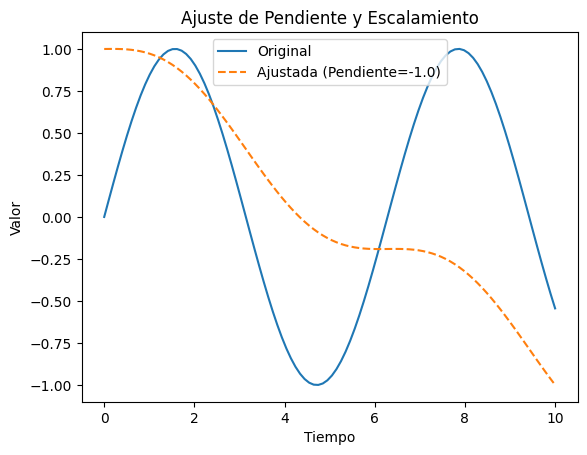

In [26]:
import numpy as np
from sklearn.linear_model import LinearRegression

def ajustar_pendiente_y_escalar(serie_temporal, pendiente_objetivo, tiempo=None):
    """
    Ajusta una serie temporal para que su pendiente de regresión sea la indicada,
    y escala los valores para que los máximos y mínimos coincidan con la serie original.

    Args:
        serie_temporal (numpy.ndarray): Serie temporal original (1D).
        pendiente_objetivo (float): Pendiente deseada para la línea de regresión.
        tiempo (numpy.ndarray, opcional): Tiempos asociados a la serie. Si no se especifica, se usará un índice lineal.

    Returns:
        numpy.ndarray: Serie temporal ajustada y escalada.
    """
    # Generar tiempo si no está dado
    if tiempo is None:
        tiempo = np.arange(len(serie_temporal))
    
    # Calcular la pendiente actual usando regresión lineal
    tiempo = tiempo.reshape(-1, 1)
    reg = LinearRegression()
    reg.fit(tiempo, serie_temporal)
    pendiente_actual = reg.coef_[0]
    
    # Calcular el ajuste necesario
    ajuste_pendiente = pendiente_objetivo - pendiente_actual
    
    # Modificar la serie para lograr la pendiente deseada
    serie_ajustada = serie_temporal + ajuste_pendiente * (tiempo.flatten() - tiempo.mean())
    
    # Escalar la serie ajustada para que sus máximos y mínimos coincidan con los originales
    min_original, max_original = serie_temporal.min(), serie_temporal.max()
    min_ajustada, max_ajustada = serie_ajustada.min(), serie_ajustada.max()
    
    # Escalamiento lineal
    serie_escalada = ((serie_ajustada - min_ajustada) / (max_ajustada - min_ajustada)) * (max_original - min_original) + min_original
    
    return serie_escalada

# Ejemplo de uso
time = np.linspace(0, 10, 100)  # Tiempo
serie_original = np.sin(time)  # Serie temporal original

# Ajustar la pendiente y escalar
pendiente_objetivo = -1.
serie_ajustada_y_escalada = ajustar_pendiente_y_escalar(serie_original, pendiente_objetivo, time)

# Visualización
import matplotlib.pyplot as plt

plt.plot(time, serie_original, label="Original")
plt.plot(time, serie_ajustada_y_escalada, label=f"Ajustada (Pendiente={pendiente_objetivo})", linestyle="--")
plt.legend()
plt.title("Ajuste de Pendiente y Escalamiento")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.show()

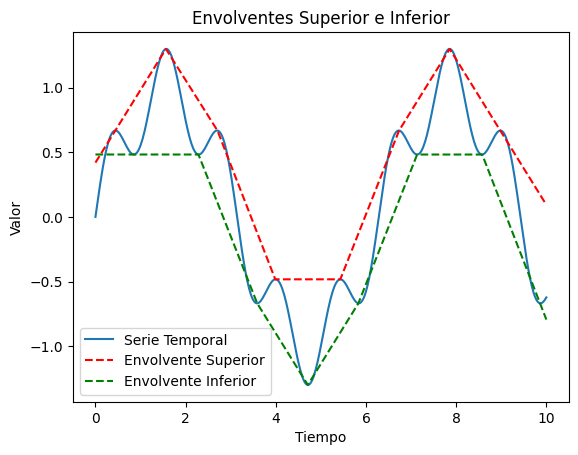

In [42]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def extraer_envolventes(serie_temporal, tiempo=None):
    """
    Extrae las envolventes superior e inferior de una serie temporal.

    Args:
        serie_temporal (numpy.ndarray): Serie temporal (1D).
        tiempo (numpy.ndarray, opcional): Tiempos asociados a la serie. Si no se especifica, se usa un índice lineal.

    Returns:
        tuple: (envolvente_superior, envolvente_inferior)
    """
    if tiempo is None:
        tiempo = np.arange(len(serie_temporal))
    
    # Encontrar picos máximos (envolvente superior)
    picos_superior, _ = find_peaks(serie_temporal)
    # Encontrar picos mínimos (envolvente inferior)
    picos_inferior, _ = find_peaks(-serie_temporal)
    
    # Interpolación para generar las envolventes
    interp_superior = interp1d(tiempo[picos_superior], serie_temporal[picos_superior], 
                               kind="linear", bounds_error=False, fill_value="extrapolate")
    interp_inferior = interp1d(tiempo[picos_inferior], serie_temporal[picos_inferior], 
                               kind="linear", bounds_error=False, fill_value="extrapolate")
    
    envolvente_superior = interp_superior(tiempo)
    envolvente_inferior = interp_inferior(tiempo)
    
    return envolvente_superior, envolvente_inferior

# Ejemplo de uso
time = np.linspace(0, 10, 500)
serie_temporal = np.sin(time) + 0.3 * np.sin(5 * time)  # Señal compuesta

envolvente_superior, envolvente_inferior = extraer_envolventes(serie_temporal, time)

# Visualización
plt.plot(time, serie_temporal, label="Serie Temporal")
plt.plot(time, envolvente_superior, label="Envolvente Superior", linestyle="--", color="red")
plt.plot(time, envolvente_inferior, label="Envolvente Inferior", linestyle="--", color="green")
plt.legend()
plt.title("Envolventes Superior e Inferior")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.show()


[  0  22  42  78 114 135 179 199 235 271 291 336 356 392 428 448 492 499]


<module 'matplotlib.pyplot' from '/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/matplotlib/pyplot.py'>

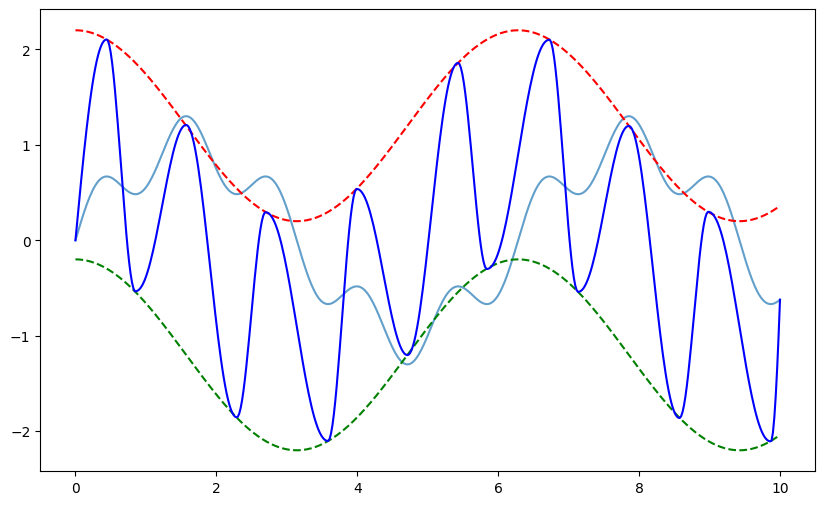

In [48]:
import numpy as np
from scipy.signal import argrelextrema

def ajustar_a_envolventes_preservando_forma(señal_original, envolvente_superior, envolvente_inferior):
    """
    Ajusta una señal para que sus máximos y mínimos locales coincidan exactamente con las envolventes,
    preservando la forma original de la señal.

    Args:
        señal_original (numpy.ndarray): Señal original (1D).
        envolvente_superior (numpy.ndarray): Envolvente superior (1D).
        envolvente_inferior (numpy.ndarray): Envolvente inferior (1D).

    Returns:
        numpy.ndarray: Señal ajustada respetando las envolventes y preservando la forma.
    """
    # Verificar que las envolventes tengan el mismo tamaño que la señal original
    if len(señal_original) != len(envolvente_superior) or len(señal_original) != len(envolvente_inferior):
        raise ValueError("Las envolventes y la señal original deben tener el mismo tamaño.")
    
    # Detectar máximos y mínimos locales
    maximos_locales = argrelextrema(señal_original, np.greater)[0]
    minimos_locales = argrelextrema(señal_original, np.less)[0]
    puntos_extremos = np.sort(np.concatenate([[0, len(señal_original)-1], maximos_locales, minimos_locales]))
    print(puntos_extremos)
    
    # Inicializar la señal ajustada
    señal_ajustada = np.copy(señal_original)
    
    # Ajustar cada segmento entre extremos
    for i in range(len(puntos_extremos) - 1):
        inicio = puntos_extremos[i]
        fin = puntos_extremos[i + 1]
        
        # Valores originales y target en los extremos
        valor_inicio = señal_original[inicio]
        valor_fin = señal_original[fin]
        
        if valor_inicio > valor_fin:  # Máximo seguido de mínimo
            target_inicio = envolvente_superior[inicio] if inicio != 0 else señal_original[0]
            target_fin = envolvente_inferior[fin] if fin != len(señal_original) -1 else señal_original[-1]
        else:  # Mínimo seguido de máximo
            target_inicio = envolvente_inferior[inicio] if inicio != 0 else señal_original[0]
            target_fin = envolvente_superior[fin] if fin != len(señal_original) -1 else señal_original[-1]
        
        # Escalar el segmento para que los extremos coincidan con las envolventes
        segmento_original = señal_original[inicio:fin + 1]
        segmento_ajustado = (segmento_original - valor_inicio) / (valor_fin - valor_inicio)  # Normalizar
        segmento_ajustado = segmento_ajustado * (target_fin - target_inicio) + target_inicio  # Escalar
        
        # Actualizar la señal ajustada
        señal_ajustada[inicio:fin + 1] = segmento_ajustado
    
    return señal_ajustada

# Ejemplo de uso
time = np.linspace(0, 10, 500)
# Señal original
señal_original = np.sin(time) + 0.3 * np.sin(5 * time)
# Envolventes de otra señal
envolvente_superior = np.cos(time) + 1.2
envolvente_inferior = np.cos(time) - 1.2

# Ajustar la señal original para que respete exactamente las envolventes
señal_ajustada = ajustar_a_envolventes_preservando_forma(señal_original, envolvente_superior, envolvente_inferior)

# Visualización
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(time, señal_original, label="Señal Original", alpha=0.7)
plt.plot(time, envolvente_superior, label="Envolvente Superior", linestyle="--", color="red")
plt.plot(time, envolvente_inferior, label="Envolvente Inferior", linestyle="--", color="green")
plt.plot(time, señal_ajustada, label="Señal Ajustada", color="blue")
plt
